In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Flatten, BatchNormalization, Conv2D, MaxPool2D,Dropout
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix
import itertools
import os
import shutil
import random
import glob
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
%matplotlib inline


In [2]:
from tensorflow.python.client import device_lib

device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 90209235653734366,
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 2258055988
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 14260907193483248731
 physical_device_desc: "device: 0, name: NVIDIA GeForce GTX 1650, pci bus id: 0000:01:00.0, compute capability: 7.5"]

In [51]:
from tensorflow.python.client import device_lib

device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 10169016497687584957,
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 2258055988
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 11235448551876012656
 physical_device_desc: "device: 0, name: NVIDIA GeForce GTX 1650, pci bus id: 0000:01:00.0, compute capability: 7.5"]

In [52]:
train_path='D:\DUmDum\deepfakes\dataset\Train'
valid_path='D:\DUmDum\deepfakes\dataset\Validation'
test_path='D:\DUmDum\deepfakes\dataset\Test'

In [53]:
train_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input)\
                .flow_from_directory(directory=train_path, target_size=(256,256),classes=['Fake','Real'],batch_size=10)
valid_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input)\
                .flow_from_directory(directory=valid_path, target_size=(256,256),classes=['Fake','Real'],batch_size=10)
test_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input)\
                .flow_from_directory(directory=test_path, target_size=(256,256),classes=['Fake','Real'],batch_size=10)

Found 140002 images belonging to 2 classes.
Found 39428 images belonging to 2 classes.
Found 10905 images belonging to 2 classes.


In [54]:
assert train_batches.n == 140002
assert valid_batches.n == 39428
assert test_batches.n == 10905
assert train_batches.num_classes == valid_batches.num_classes == test_batches.num_classes == 2

In [55]:
train_batches.classes

array([0, 0, 0, ..., 1, 1, 1])

In [56]:
imgs, labels =next(train_batches)

In [57]:
def plotImages(images_arr):
    fig, axes = plt.subplots(1,10,figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

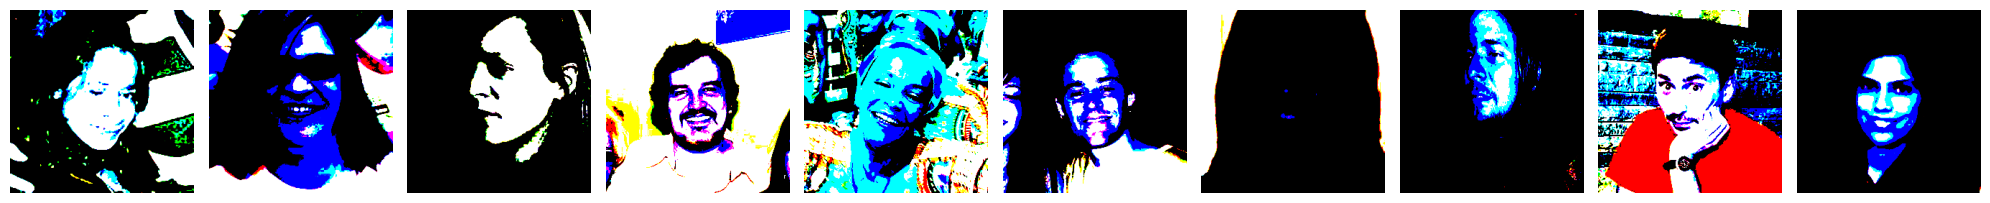

[[1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]]


In [58]:
plotImages(imgs)
print(labels)

In [67]:
model = Sequential([
        Conv2D(filters=16, kernel_size=(3,3),activation='relu',padding='same',input_shape=(256,256,3)),
        MaxPool2D(pool_size=(2,2),strides = 2),
        Dropout(0.2),
        Conv2D(filters=32, kernel_size=(3,3), strides = 1 ,activation = 'relu' , padding = 'same'),
        MaxPool2D(pool_size=(2,2),strides=2 ),
        Dropout(0.2),
        Conv2D(filters=64, kernel_size=(3,3), strides = 1 ,activation = 'relu' , padding = 'same'),
        MaxPool2D(pool_size=(2,2),strides=2 ),
        Dropout(0.2),
        Conv2D(filters=128, kernel_size=(3,3), strides = 1 ,activation = 'relu' , padding = 'same'),
        MaxPool2D(pool_size=(2,2),strides=2 ),
        Flatten(),
        Dense(units=2, activation='softmax'), 
])

In [68]:
model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_31 (Conv2D)           (None, 256, 256, 16)      448       
_________________________________________________________________
max_pooling2d_31 (MaxPooling (None, 128, 128, 16)      0         
_________________________________________________________________
dropout_18 (Dropout)         (None, 128, 128, 16)      0         
_________________________________________________________________
conv2d_32 (Conv2D)           (None, 128, 128, 32)      4640      
_________________________________________________________________
max_pooling2d_32 (MaxPooling (None, 64, 64, 32)        0         
_________________________________________________________________
dropout_19 (Dropout)         (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_33 (Conv2D)           (None, 64, 64, 64)       

In [69]:
tf.test.is_gpu_available()

True

In [70]:
from tensorflow.python.client import device_lib
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [71]:
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 6654904198731602516,
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 2258055988
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 7058800402210373754
 physical_device_desc: "device: 0, name: NVIDIA GeForce GTX 1650, pci bus id: 0000:01:00.0, compute capability: 7.5"]

In [72]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  # Restrict TensorFlow to only use the first GPU
  try:
    tf.config.set_visible_devices(gpus[0], 'GPU')
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")
  except RuntimeError as e:
    # Visible devices must be set before GPUs have been initialized
    print(e)

1 Physical GPUs, 1 Logical GPU


In [73]:
model.compile(loss="binary_crossentropy",optimizer=SGD(learning_rate = 0.0001, momentum=0.9), metrics=['binary_accuracy'])

In [74]:
history = model.fit(x=train_batches,validation_data=valid_batches,epochs=10,verbose=1)

Epoch 1/10
14001/14001 [==============================] - 1736s 124ms/step - loss: 0.4084 - binary_accuracy: 0.8250 - val_loss: 0.3154 - val_binary_accuracy: 0.8669
Epoch 2/10
14001/14001 [==============================] - 1650s 118ms/step - loss: 0.2312 - binary_accuracy: 0.9037 - val_loss: 0.2497 - val_binary_accuracy: 0.8971
Epoch 3/10
14001/14001 [==============================] - 1659s 118ms/step - loss: 0.1881 - binary_accuracy: 0.9238 - val_loss: 0.2315 - val_binary_accuracy: 0.9046
Epoch 4/10
14001/14001 [==============================] - 1670s 119ms/step - loss: 0.1656 - binary_accuracy: 0.9329 - val_loss: 0.2148 - val_binary_accuracy: 0.9123
Epoch 5/10
14001/14001 [==============================] - 1546s 110ms/step - loss: 0.1511 - binary_accuracy: 0.9394 - val_loss: 0.2005 - val_binary_accuracy: 0.9209
Epoch 6/10
14001/14001 [==============================] - 1518s 108ms/step - loss: 0.1405 - binary_accuracy: 0.9441 - val_loss: 0.1831 - val_binary_accuracy: 0.9264
Epoch 7/10

In [75]:
test_batches.classes

array([0, 0, 0, ..., 1, 1, 1])

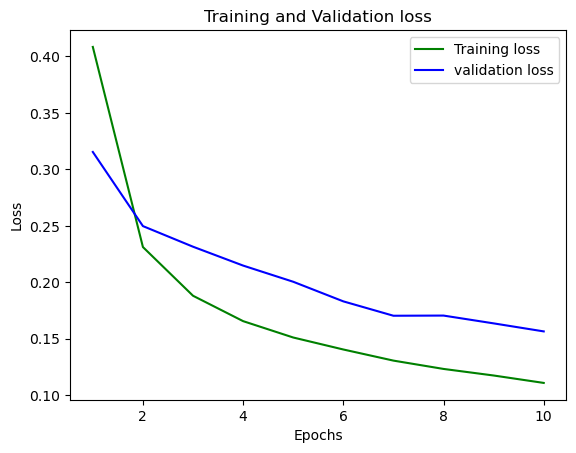

In [76]:
loss_train = history.history['loss']
loss_val = history.history['val_loss']
epochs = range(1,11)
plt.plot(epochs, loss_train, 'g', label='Training loss')
plt.plot(epochs, loss_val, 'b', label='validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

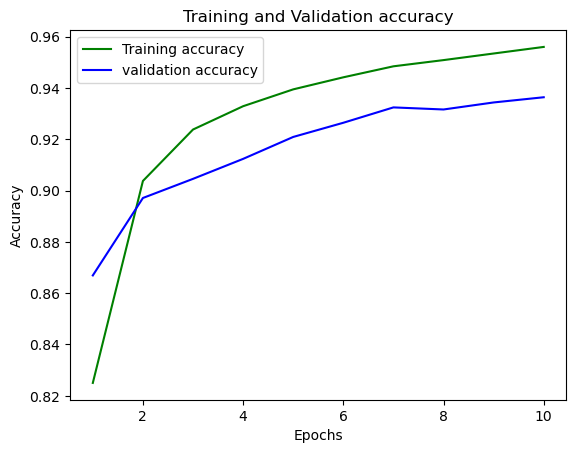

In [88]:
loss = history.history['binary_accuracy']
val_loss = history.history['val_binary_accuracy']
epochs = range(1,11)
plt.plot(epochs, loss, 'g', label='Training accuracy')
plt.plot(epochs, val_loss, 'b', label='validation accuracy')
plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [86]:
model.metrics_names

['loss', 'binary_accuracy']

In [78]:
predictions = model.predict(x=test_batches,verbose=1)

1091/1091 [==============================] - 106s 97ms/step


In [80]:
np.round(predictions)

array([[0., 1.],
       [1., 0.],
       [0., 1.],
       ...,
       [0., 1.],
       [0., 1.],
       [1., 0.]], dtype=float32)

In [81]:
cm=confusion_matrix(y_true=test_batches.classes, y_pred=np.argmax(predictions,axis=-1))

In [82]:
def plot_confusion_matrix(cm,classes,
                          normalize=False,
                          title='confusion matrix',
                          cmap=plt.cm.Blues):
    plt.imshow(cm,interpolation='nearest',cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks=np.arange(len(classes))
    plt.xticks(tick_marks,classes,rotation =45)
    plt.yticks(tick_marks,classes)
    
    if normalize:
        cm=cm.astype('float')/cm.sum(axis=1)[:,np.newaxis]
        print("Normalized confusion Matrix")
    else:
        print("Confusion Matrix,without normalization")
        
    print(cm)
    
    thresh = cm.max()/2.
    for i,j in itertools.product(range(cm.shape[0]),range(cm.shape[1])):
        plt.text(j,i,cm[i,j]),
        horizontalalignment="center",
        color="white" if cm[i,j]>thresh else "black"
    
    plt.tight_layout()
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    

In [83]:
test_batches.class_indices

{'Fake': 0, 'Real': 1}

Confusion Matrix,without normalization
[[2992 2500]
 [2938 2475]]


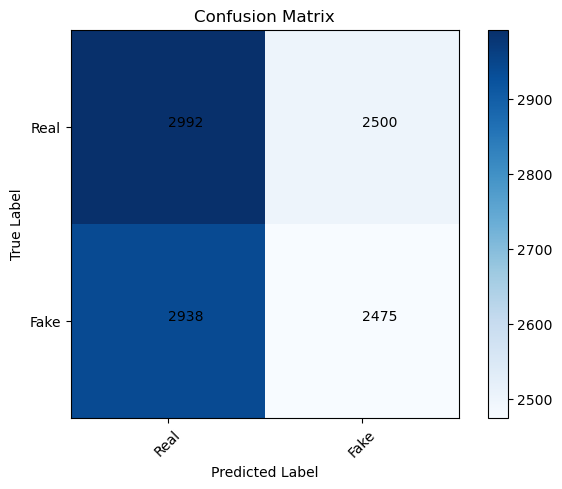

In [98]:
cm_plot_labels=['Real','Fake']
plot_confusion_matrix(cm=cm,classes=cm_plot_labels,title='Confusion Matrix')

In [ ]:
#import os.path
#if os.path.isfile('D:\DUmDum\deepfakes\DFmodel\DF.h5') is False:
    #model.save('D:\DUmDum\deepfakes\DFmodel\df2.h5')

In [99]:
from sklearn.metrics import accuracy_score, classification_report

In [102]:
#classification_report(test_batches.classes , np.round(predictions))